In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date, time, timedelta, datetime
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import Dataset
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
import gc 
from statistics import mean, median, stdev
import pickle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final.zip", index_col=0)

In [ ]:
new_df.drop(['public_date', 'start_price', 'end_price', 'TICKER', 'price_year_before', 'date_before_year', 'adate', 'qdate', 'permno', 'CUSIP'], axis=1).columns

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm',
       'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx',
       'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'PEG_1yrforward', 'PEG_ltgforward', 'cusip', 'growth',
       'momentum'],
      

In [ ]:
    
# For rnn
class CompanyDatasetRNN(Dataset):
    """
    Custom torch dataset class for the annotated images

    """
    SIZE_OF_SEQ = 9
    def __init__(self, df):
        self.standardize(df)
        
    
    def standardize(self, df):
        df_tmp = df.drop(['TICKER', 'price_year_before', 'date_before_year', 'adate', 'qdate', 'CUSIP', 'cusip'], axis=1)
        
        cols = df_tmp.columns
        no_scaling = ['permno', 'public_date', 'growth', 'start_price', 'end_price']
        for col in cols:
          if not col in no_scaling:
            df_tmp[col] = StandardScaler().fit_transform(np.array(df_tmp[col]).reshape(-1,1))
        df_tmp = df_tmp.groupby('permno')
        self.collate(df_tmp)
    
    def collate(self, data):
        # Here dataset is chunked so it can be used in rnn
        new_features = []
        labels = []
        prices = []
        for company in data:
            company = company[1]
            for i in range(len(company)-(self.SIZE_OF_SEQ-1)):
                batch = company.head(self.SIZE_OF_SEQ)
                feature = batch.drop(['growth', 'public_date', 'permno', 'start_price', 'end_price'], axis=1)
                feature = torch.tensor(feature.values)
                label = 1+(batch.iloc[0]['growth'])
                price = batch.iloc[0][['start_price', 'end_price']]
                new_features.append(feature)
                labels.append(label)
                prices.append(price)
                company = company.tail(len(company)-1)

        self.features, self.growth, self.prices = new_features, labels, prices


    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        growth = self.growth[idx]
        prices = self.prices[idx].tolist()
        return features, growth, prices


In [ ]:
class RNN(nn.Module):
    def __init__(self, embed_size, hidden_size):
        """
        Args:
          src_dictionary_size: The number of words in the source dictionary.
          embed_size: The number of dimensions in the word embeddings.
          hidden_size: The number of features in the hidden state of GRU.
        """
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.lstm = nn.LSTM(input_size=72, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(72, hidden_size)
        self.fc2 = nn.Linear(hidden_size,1)
        self.relu = nn.ReLU()


    def forward(self, x, hidden):
        """
        Args:
          pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
          seq_lengths: List of sequence lengths.
          hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

        Returns:
          outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """
        #x = self.relu(self.fc1(x))
        out, hidden = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc2(self.relu(out))
        return out, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(2, batch_size, self.hidden_size)
    

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
df = new_df.head(int(len(new_df))).sort_values('public_date', ascending=False).fillna(0)

n_test = int(0.135 * len(df))
n_val = n_test
n_train = len(df) - (n_test+n_val)

print(f"Train size: {n_train}, test size: {n_test}, val size: {n_val}")
assert len(df) == (n_test + n_val + n_train)
assert df.iloc[0]['public_date'] >= df.iloc[1]['public_date']
assert df.iloc[0]['public_date'] > df.iloc[-1]['public_date']

train_df = df.tail(n_train)
test_val_df = df.head(n_test+n_val)
val_df = test_val_df.tail(n_val)
test_df = test_val_df.head(n_test)
assert train_df.iloc[0]['public_date'] <= val_df.iloc[-1]['public_date']
assert len(train_df) > 17000 and len(val_df) > 17000 and len(test_df) > 17000


with open("/content/drive/MyDrive/Colab Notebooks/permnos", "rb") as fp:   # Unpickling
    permnos = pickle.load(fp)
test_df = test_df[test_df['permno'].isin(permnos)]
print(len(test_df))



ds_train = CompanyDatasetRNN(train_df)
print("Trainset done")
ds_val = CompanyDatasetRNN(val_df)
print("Valset done")
ds_test = CompanyDatasetRNN(test_df)
print("Testset done")


Train size: 594761, test size: 109989, val size: 109989
92204
Trainset done
Valset done
Testset done


In [ ]:
dl_train = DataLoader(ds_train, batch_size=batch_size, drop_last=True, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, drop_last=True, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=64, drop_last=True, shuffle=True)


In [ ]:
def print_progress(epoch, train_error, val_error, lr):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}, lr: {}'.format(
        epoch, train_error, val_error, lr))
def compute_loss(mlp, dl):
    mlp.eval()
    tot_loss = 0
    with torch.no_grad():
        for batch in dl:
            hidden = mlp.init_hidden(batch_size).to(device)
            x, y, _ = batch
            x, y = x.to(device), y.to(device)
            outputs, hidden = mlp.forward(x.float(), hidden)
            tot_loss += F.mse_loss(outputs, y.reshape(-1,1))
            #tot_loss += F.l1_loss(outputs, y)
        return (tot_loss)/len(dl)

Epoch 0, 0%
Epoch 0, 12%
Epoch 0, 24%
Epoch 0, 36%
Epoch 0, 48%
Epoch 0, 60%
Epoch 0, 72%
Epoch 0, 84%
Epoch 0, 96%
Epoch 0: Train error: 2.0309, Test error: 5.4773, lr: 0.001
Epoch 1, 0%
Epoch 1, 12%
Epoch 1, 24%
Epoch 1, 36%
Epoch 1, 48%
Epoch 1, 60%
Epoch 1, 72%
Epoch 1, 84%
Epoch 1, 96%
Epoch 1: Train error: 1.9553, Test error: 5.4230, lr: 0.001
Epoch 2, 0%
Epoch 2, 12%
Epoch 2, 24%
Epoch 2, 36%
Epoch 2, 48%
Epoch 2, 60%
Epoch 2, 72%
Epoch 2, 84%
Epoch 2, 96%
Epoch 2: Train error: 1.9064, Test error: 5.3759, lr: 0.001
Epoch 3, 0%
Epoch 3, 12%
Epoch 3, 24%
Epoch 3, 36%
Epoch 3, 48%
Epoch 3, 60%
Epoch 3, 72%
Epoch 3, 84%
Epoch 3, 96%
Epoch 3: Train error: 1.8375, Test error: 5.3496, lr: 0.0001
Epoch 4, 0%
Epoch 4, 12%
Epoch 4, 24%
Epoch 4, 36%
Epoch 4, 48%
Epoch 4, 60%
Epoch 4, 72%
Epoch 4, 84%
Epoch 4, 96%
Epoch 4: Train error: 1.8155, Test error: 5.3580, lr: 0.0001
Epoch 5, 0%
Epoch 5, 12%
Epoch 5, 24%
Epoch 5, 36%
Epoch 5, 48%
Epoch 5, 60%
Epoch 5, 72%
Epoch 5, 84%
Epoch 5, 96%
Ep

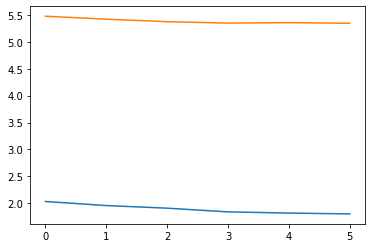

In [ ]:
hidden_size = embed_size = 16
model = RNN(embed_size, hidden_size)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Implement the training loop in this cell
if True:
    n_epochs = 6
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-9, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        for idx, batch in enumerate(dl_train):
            hidden = model.init_hidden(batch_size=batch_size).to(device)
            features, growths, _ = batch
            features, growths = features.to(device), growths.to(device)
            optimizer.zero_grad()
            outputs, hidden = model.forward(features.float(), hidden)
            #loss = F.l1_loss(outputs, growths.float())
            loss = F.mse_loss(outputs, growths.float().reshape(-1,1))
            loss.backward()

            optimizer.step()
            running_loss += loss
            if idx % 1000 == 0:
                print(f"Epoch {epoch}, {int(idx/len(dl_train)*100)}%")

        lr = scheduler.get_last_lr()[0]
        train_errors.append(running_loss/len(dl_train))
        val_errors.append(compute_loss(model, dl_val))
        print_progress(epoch, train_errors[-1], val_errors[-1], lr)
        running_loss = 0
        gc.collect()
        scheduler.step()
            
    plt.plot(torch.stack(train_errors).cpu().detach())
    plt.plot(torch.stack(val_errors).cpu().detach())
    plt.show()

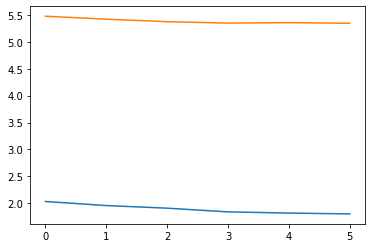

In [ ]:
plt.plot(torch.stack(train_errors).cpu().detach())
plt.plot(torch.stack(val_errors).cpu().detach())
plt.show()
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/rnngoodmabye.pth")

In [ ]:
def r_squared(preds, targets, y_bar):
    ss_tot = ((targets - preds)**2).sum()
    ss_res = ((targets - y_bar)**2).sum()
    return 1 - (ss_tot/ss_res)


In [ ]:
'''
ds_test = CompanyDatasetRNN(test_df)
'''
hidden_size = embed_size = 16
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RNN(embed_size, hidden_size)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/rnngoodmabye.pth", map_location=torch.device(device)))
model.to(device)
preds_list = []
growths_list = []
prices_list = []
accuracy_levels = []
with torch.no_grad():
    for batch in dl_test:
        features, growths, prices = batch
        features, growths = features.to(device), growths.to(device)
        hidden = model.init_hidden(batch_size=batch_size).to(device)
        preds, hidden = model.forward(features.float(), hidden)
        preds_list += preds[:, 0].tolist()
        growths_list += growths.tolist()
        prices_list += prices
        accuracy_level = 1 - abs(((1+growths)/(1+preds)[:, 0])-1)
        accuracy_levels += accuracy_level.tolist()
    r2 = r_squared(pd.Series(preds_list), pd.Series(growths_list), 1.09783173099033)
print(f"Test R2: {r2}")
print(f"Accuracy level median: {median(accuracy_levels)}, Mean: {mean(accuracy_levels)}, Std; {stdev(accuracy_levels)}")
print(pd.Series(growths_list).describe())
print(pd.Series(preds_list).describe())
print(test_df)

Test R2: 0.04768943137363324
Accuracy level median: 0.8316985331298603, Mean: 0.7054881609991223, Std; 0.8823276593075866
count    68480.000000
mean         1.439412
std          2.693380
min          0.021845
25%          0.794273
50%          1.070295
75%          1.457672
max        209.708274
dtype: float64
count    68480.000000
mean         1.316929
std          0.762830
min          0.817474
25%          1.022351
50%          1.084986
75%          1.233372
max          8.562413
dtype: float64
         permno       adate     qdate public_date   CAPEI     bm     evm  \
1128026   80577  20191231.0  20200930  2020-11-30   0.000  0.465  -3.584   
1102989   15914  20191231.0  20200930  2020-11-30 -68.075  0.000 -36.790   
1061460   91968  20200930.0  20200930  2020-11-30  57.604  0.406  46.892   
94825     77462  20200131.0  20200731  2020-11-30   5.292  1.726  58.689   
1104015   93426  20191231.0  20200930  2020-11-30  31.959  0.744  11.434   
...         ...         ...       ...   

In [ ]:
gc.collect()
growths, preds = growths, preds
#tgt_prices = prices[1]
#tgt_ish = prices[0] * (growths)

#pred_prices = prices[0] * (preds)

accuracy_level = 1 - abs((prices[1].to(device)/(prices[0].to(device) * (preds))-1))
#test = accuracy_level.sort_values()
print(accuracy_level.describe())


print(accuracy_level)

RuntimeError: ignored